<a href="https://colab.research.google.com/github/michelmalki/MichelMalki/blob/main/Fintech_Recommendation_AB_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Fintech Product Recommendation System with A/B/n Testing and Personalization

This notebook demonstrates a financial product recommender system with the following features:
- A/B/n Testing (Multi-armed)
- User Segmentation
- Real Engagement Signals (Clicks, Conversions, Application Completions)
- Bayesian Optimization for Dynamic Allocation
- ROAS (Return on Ad Spend) and MOAS (Margin on Ad Spend) calculation
- Interactive Personalization Dashboard (via `panel` or `streamlit` suggestion)


In [1]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta
import random
import warnings
warnings.filterwarnings("ignore")


In [2]:

# Simulate user segments and engagement signals
np.random.seed(42)
n_users = 1000
segments = ['Young Investors', 'Retirees', 'High Net Worth', 'Newcomers']
products = ['ETF Plan', 'Crypto Wallet', 'Retirement Fund', 'Robo Advisor']

users = pd.DataFrame({
    'user_id': np.arange(n_users),
    'segment': np.random.choice(segments, n_users),
    'product_exposed': np.random.choice(products, n_users),
    'click': np.random.binomial(1, 0.3, n_users),
    'conversion': np.random.binomial(1, 0.1, n_users),
    'application_complete': np.random.binomial(1, 0.05, n_users),
    'ad_spend': np.random.uniform(1, 10, n_users)
})
users['revenue'] = users['conversion'] * np.random.uniform(100, 500, n_users)


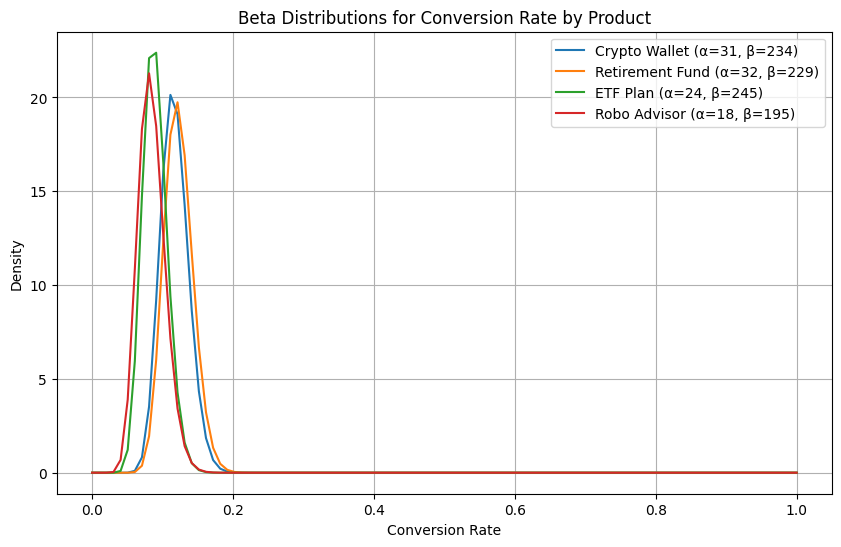

In [3]:

# Bayesian A/B/n allocation using Beta distribution
def plot_beta_distributions(data):
    plt.figure(figsize=(10, 6))
    for product in data['product_exposed'].unique():
        subset = data[data['product_exposed'] == product]
        alpha = 1 + subset['conversion'].sum()
        beta_ = 1 + (len(subset) - subset['conversion'].sum())
        x = np.linspace(0, 1, 100)
        y = beta.pdf(x, alpha, beta_)
        plt.plot(x, y, label=f"{product} (α={alpha}, β={beta_})")
    plt.legend()
    plt.title("Beta Distributions for Conversion Rate by Product")
    plt.xlabel("Conversion Rate")
    plt.ylabel("Density")
    plt.grid(True)
    plt.show()

plot_beta_distributions(users)


In [4]:

# ROAS = Revenue / Ad Spend
# MOAS = (Revenue - Cost) / Ad Spend
users['ROAS'] = users['revenue'] / users['ad_spend']
users['MOAS'] = (users['revenue'] - users['ad_spend']) / users['ad_spend']

# Average ROAS and MOAS per segment and product
kpis = users.groupby(['segment', 'product_exposed'])[['ROAS', 'MOAS']].mean().reset_index()
kpis.sort_values(by='ROAS', ascending=False)


,segment,product_exposed,ROAS,MOAS
12,Young Investors,Crypto Wallet,10.732406,9.732406
0,High Net Worth,Crypto Wallet,9.481258,8.481258
6,Newcomers,Retirement Fund,9.306669,8.306669
8,Retirees,Crypto Wallet,9.085587,8.085587
2,High Net Worth,Retirement Fund,8.581762,7.581762
15,Young Investors,Robo Advisor,8.402196,7.402196
14,Young Investors,Retirement Fund,8.103543,7.103543
9,Retirees,ETF Plan,7.657674,6.657674
4,Newcomers,Crypto Wallet,7.452231,6.452231
10,Retirees,Retirement Fund,6.687391,5.687391


In [5]:

# Recommend product based on segment
rules = {
    'Young Investors': 'Crypto Wallet',
    'Retirees': 'Retirement Fund',
    'High Net Worth': 'Robo Advisor',
    'Newcomers': 'ETF Plan'
}
users['recommended_product'] = users['segment'].map(rules)
users[['user_id', 'segment', 'recommended_product']].head()


,user_id,segment,recommended_product
0,0,High Net Worth,Robo Advisor
1,1,Newcomers,ETF Plan
2,2,Young Investors,Crypto Wallet
3,3,High Net Worth,Robo Advisor
4,4,High Net Worth,Robo Advisor



## Interactive Dashboard Suggestion

You can extend this notebook with `panel` or export to `streamlit` for live interaction:

```python
import panel as pn
pn.extension()

def dashboard_view(segment):
    filtered = users[users['segment'] == segment]
    return filtered.groupby('product_exposed')[['conversion', 'ROAS', 'MOAS']].mean()

pn.interact(dashboard_view, segment=segments)
```


In [6]:
!pip install panel matplotlib pandas numpy


Launching server at http://localhost:46769


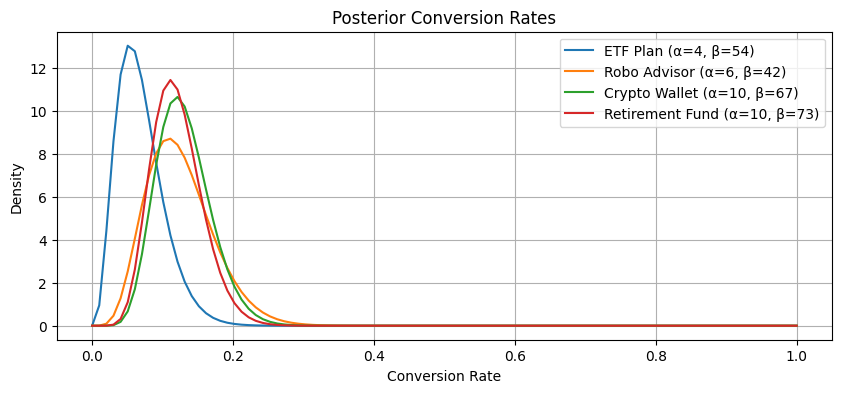

In [7]:
import panel as pn
import pandas as pd
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt

pn.extension('plotly')

np.random.seed(42)
n_users = 1000
segments = ['Young Investors', 'Retirees', 'High Net Worth', 'Newcomers']
products = ['ETF Plan', 'Crypto Wallet', 'Retirement Fund', 'Robo Advisor']

users = pd.DataFrame({
    'user_id': np.arange(n_users),
    'segment': np.random.choice(segments, n_users),
    'product_exposed': np.random.choice(products, n_users),
    'click': np.random.binomial(1, 0.3, n_users),
    'conversion': np.random.binomial(1, 0.1, n_users),
    'application_complete': np.random.binomial(1, 0.05, n_users),
    'ad_spend': np.random.uniform(1, 10, n_users)
})
users['revenue'] = users['conversion'] * np.random.uniform(100, 500, n_users)
users['ROAS'] = users['revenue'] / users['ad_spend']
users['MOAS'] = (users['revenue'] - users['ad_spend']) / users['ad_spend']

rules = {
    'Young Investors': 'Crypto Wallet',
    'Retirees': 'Retirement Fund',
    'High Net Worth': 'Robo Advisor',
    'Newcomers': 'ETF Plan'
}
users['recommended_product'] = users['segment'].map(rules)

segment_selector = pn.widgets.Select(name='Choose Segment', options=segments)

@pn.depends(segment_selector)
def show_dashboard(segment):
    filtered = users[users['segment'] == segment]
    summary = filtered.groupby('product_exposed')[['conversion', 'ROAS', 'MOAS']].mean()

    fig, ax = plt.subplots(figsize=(10, 4))
    for product in filtered['product_exposed'].unique():
        subset = filtered[filtered['product_exposed'] == product]
        alpha = 1 + subset['conversion'].sum()
        beta_ = 1 + (len(subset) - subset['conversion'].sum())
        x = np.linspace(0, 1, 100)
        y = beta.pdf(x, alpha, beta_)
        ax.plot(x, y, label=f"{product} (α={alpha}, β={beta_})")
    ax.set_title("Posterior Conversion Rates")
    ax.set_xlabel("Conversion Rate")
    ax.set_ylabel("Density")
    ax.legend()
    ax.grid(True)

    return pn.Column(
        f"### 🎯 Recommended Product: **{rules[segment]}**",
        pn.pane.DataFrame(summary, width=600),
        pn.pane.Matplotlib(fig, tight=True)
    )

dashboard = pn.Column(
    "# 📊 Fintech Product Recommender",
    segment_selector,
    show_dashboard
)

dashboard.show()


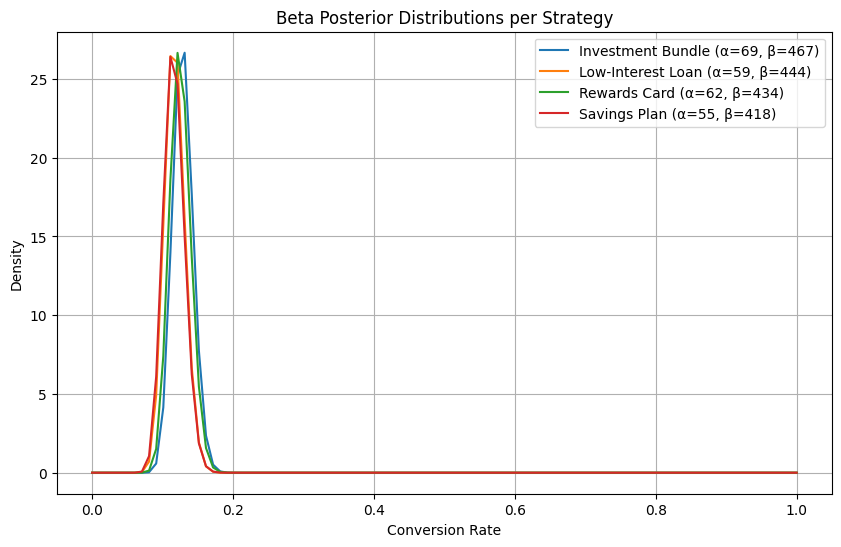

In [8]:
# Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

np.random.seed(42)

# Simulate Segmentation + Multi-Arms
n_users = 2000
users = pd.DataFrame({
    'user_id': np.arange(n_users),
    'age_band': np.random.choice(['18-25', '26-35', '36-50', '51+'], n_users),
    'income_tier': np.random.choice(['Low', 'Medium', 'High'], n_users),
    'risk_profile': np.random.choice(['Conservative', 'Balanced', 'Aggressive'], n_users),
    'strategy_exposed': np.random.choice([
        'Savings Plan', 'Rewards Card', 'Investment Bundle', 'Low-Interest Loan'
    ], n_users)
})

# Simulated engagement
users['click'] = np.random.binomial(1, 0.35, n_users)
users['conversion'] = np.random.binomial(1, 0.12, n_users)
users['application_complete'] = np.random.binomial(1, 0.07, n_users)
users['ad_spend'] = np.random.uniform(1, 20, n_users)
users['revenue'] = users['conversion'] * np.random.uniform(100, 600, n_users)

# Plot Beta posterior
def plot_beta_by_strategy(data):
    plt.figure(figsize=(10, 6))
    for strat in data['strategy_exposed'].unique():
        strat_data = data[data['strategy_exposed'] == strat]
        alpha = 1 + strat_data['conversion'].sum()
        beta_ = 1 + (len(strat_data) - strat_data['conversion'].sum())
        x = np.linspace(0, 1, 100)
        y = beta.pdf(x, alpha, beta_)
        plt.plot(x, y, label=f"{strat} (α={alpha}, β={beta_})")
    plt.title("Beta Posterior Distributions per Strategy")
    plt.xlabel("Conversion Rate")
    plt.ylabel("Density")
    plt.grid(True)
    plt.legend()
    plt.show()

plot_beta_by_strategy(users)


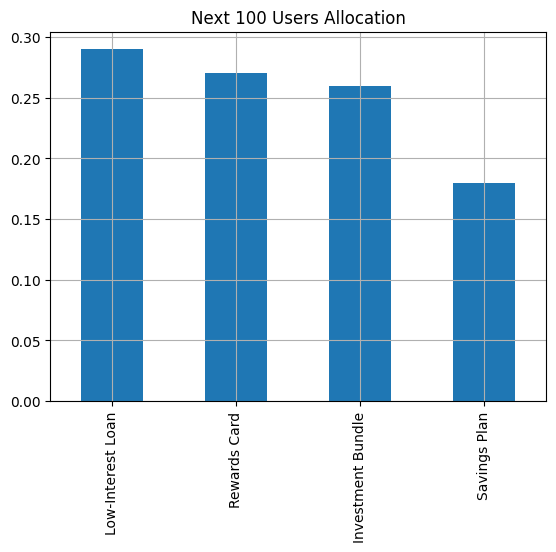

In [9]:
# Real-time strategy allocation
strategy_ctr = users.groupby('strategy_exposed')['click'].mean().sort_values(ascending=False)
weights = strategy_ctr / strategy_ctr.sum()

next_alloc = np.random.choice(strategy_ctr.index, size=100, p=weights.values)
pd.Series(next_alloc).value_counts(normalize=True).plot(kind='bar', title='Next 100 Users Allocation')
plt.grid(True)
plt.show()


In [10]:
!pip install optuna pandas matplotlib seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 18.4 MB/s eta 0:00:00


In [11]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import random

np.random.seed(42)


In [12]:
def objective(trial):
    weight_A = trial.suggest_float("weight_A", 0.0, 1.0)
    weight_B = trial.suggest_float("weight_B", 0.0, 1.0)
    weight_C = trial.suggest_float("weight_C", 0.0, 1.0)
    weight_D = 1.0 - (weight_A + weight_B + weight_C)
    if weight_D < 0 or weight_D > 1:
        raise optuna.exceptions.TrialPruned()

    weights = [weight_A, weight_B, weight_C, weight_D]
    strategies = ['Savings Plan', 'Rewards Card', 'Investment Bundle', 'Low-Interest Loan']
    allocations = np.random.choice(strategies, size=1000, p=weights)

    conversions = []
    for strategy in allocations:
        base_rate = crm_df[crm_df['strategy'] == strategy]['conversion'].mean()
        conversions.append(np.random.binomial(1, base_rate))

    return np.mean(conversions)


In [15]:
# Must run this cell before defining the objective!
n_users = 5000
crm_df = pd.DataFrame({
    'customer_id': np.arange(n_users),
    'age': np.random.randint(18, 65, n_users),
    'income': np.random.choice(['Low', 'Medium', 'High'], n_users),
    'risk_profile': np.random.choice(['Conservative', 'Balanced', 'Aggressive'], n_users),
    'strategy': np.random.choice(['Savings Plan', 'Rewards Card', 'Investment Bundle', 'Low-Interest Loan'], n_users),
    'click': np.random.binomial(1, 0.3, n_users),
    'conversion': np.random.binomial(1, 0.1, n_users),
    'revenue': np.random.uniform(50, 500, n_users)
})


In [17]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# ✅ Store the result in best_weights
best_weights = study.best_params
print("📌 Best Strategy Allocation:")
print(best_weights)


[I 2025-06-27 04:42:37,157] A new study created in memory with name: no-name-5121d326-3b21-48ca-a412-3ab1f681d8ad
[I 2025-06-27 04:42:37,161] Trial 0 pruned. 
[I 2025-06-27 04:42:37,162] Trial 1 pruned. 
[I 2025-06-27 04:42:37,164] Trial 2 pruned. 
[I 2025-06-27 04:42:37,165] Trial 3 pruned. 
[I 2025-06-27 04:42:37,166] Trial 4 pruned. 
[I 2025-06-27 04:42:37,169] Trial 5 pruned. 
[I 2025-06-27 04:42:37,170] Trial 6 pruned. 
[I 2025-06-27 04:42:37,172] Trial 7 pruned. 
[I 2025-06-27 04:42:37,174] Trial 8 pruned. 
[I 2025-06-27 04:42:38,403] Trial 9 finished with value: 0.121 and parameters: {'weight_A': 0.6658067806219712, 'weight_B': 0.11797625935629319, 'weight_C': 0.12058317479105252}. Best is trial 9 with value: 0.121.
[I 2025-06-27 04:42:39,526] Trial 10 finished with value: 0.117 and parameters: {'weight_A': 0.6173418509945303, 'weight_B': 0.003116824764287651, 'weight_C': 0.007302487123021575}. Best is trial 9 with value: 0.121.
[I 2025-06-27 04:42:41,129] Trial 11 finished with

📌 Best Strategy Allocation:
{'weight_A': 0.3774311430140268, 'weight_B': 0.3601499063147512, 'weight_C': 0.131963018593092}


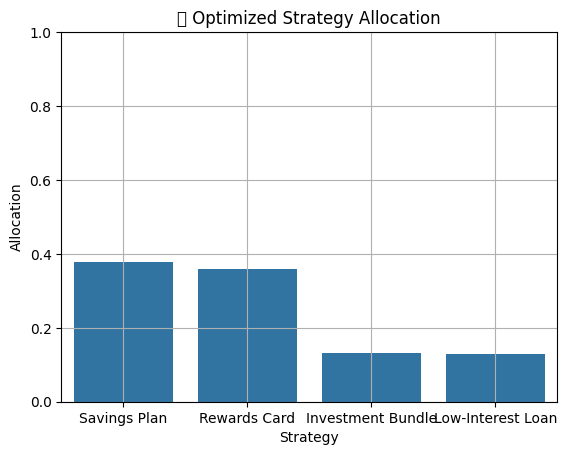

In [18]:
strategies = ['Savings Plan', 'Rewards Card', 'Investment Bundle', 'Low-Interest Loan']
weights = [
    best_weights["weight_A"],
    best_weights["weight_B"],
    best_weights["weight_C"],
    1.0 - (best_weights["weight_A"] + best_weights["weight_B"] + best_weights["weight_C"])
]

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

alloc_df = pd.DataFrame({
    'Strategy': strategies,
    'Allocation': weights
})

sns.barplot(data=alloc_df, x='Strategy', y='Allocation')
plt.title("📊 Optimized Strategy Allocation")
plt.ylim(0, 1)
plt.grid(True)
plt.show()
